# Last homework: designing a microscope using machine learning

For the final homework assignment, we will design a microscope using machine learning! In order to do this, we will combine elements of HW3 (CNNs) and HW4 (microscope simulator) into a single end-to-end architecture. In particular, we will convert the MNIST digits into phase/amplitude objects and process them through a microscope simulator as we did in HW4, add noise, and then feed the output into a CNN to classify the digit. In addition to optimizing the CNN parameters, we will also be simultaneously optimizing the input illumination incident on the sample as well as the aperture plane.

Below, we will walk you through the steps of implementing this joint architecture, leaving some portions blank for you to implement. We will first instruct you to use specific values that we have tested and are known to give reasonable results. Later on, you will revisit the code and explore different hyperparameter settings.

## 1. import stuff and load MNIST
As always, we split the dataset into training and testing. This code was copied from the jupyter notebook from TA session 5 and slightly modified.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# load MNIST dataset:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# verify that the shapes are correct:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# cast as a float32:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## 2. convert the MNIST images into microscope samples
Convert the MNIST images into phase-only objects. To do this, normalize the MNIST digits to be between 0 and 1, and make the object 1 wavelength thick (we may come back later to adjust the sample thickness).

In [2]:
wavelength = .5
def convert_MNIST(X):
    X = X / X.max()
    X_phase = X
    optical_thickness = 1 * wavelength
    X = np.exp(1j * X_phase*optical_thickness/wavelength)
    return X

X_train = convert_MNIST(X_train)
X_test = convert_MNIST(X_test)

## 3. create input pipeline for generating training/testing batches
For your convenience, this was also copied from TA session 5 (and slightly modified). You don't need to do anything here but run this block:

In [3]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.complex64, [None, 28, 28], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

Instructions for updating:
Colocations handled automatically by placer.


## 4. create complex-valued trainable illumination
The input field will be a 28x28 complex-valued field that interacts with the sample. In practice, this input field might be obtained by using a spatial light modulator (SLM), an optical element that can be programmed to display an arbitrary phase and/or amplitude pattern pixel by pixel. We will use a phase-only SLM, so that the variable to optimize is a 28x28 array of phases (from 0 to 2pi).

In [4]:
# use this flag to allow/disallow training of the input illumination; tf.Variable has an argument called "trainable":
train_illumination = True

# create the variable corresponding to the input illumination phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!
input_illumination_phase = tf.Variable(np.random.rand(28, 28)*0, trainable=train_illumination, dtype='float32')

# using that input phase, create the input field:
input_illumination = tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(input_illumination_phase))

Instructions for updating:
Use tf.cast instead.


## 5. generate the emerging field from the sample
Given a stack of input images, X_batch (generated above), create a tensorflow array representing the emerging field from the sample. This is the same as what you did in HW4, except in HW4 you had a tilted plane wave.

In [5]:
# be sure to match the shapes/dimensions to enable broadcasting:
emerging_field = tf.convert_to_tensor(input_illumination*X_batch)

## 6. propagate the emerging field to the aperture plane
As in HW4, propagate the field emerging from the sample to the aperture plane (also known as the Fourier plane). Remember to use tensorflow operations!

In [6]:
aperture_plane = tf.signal.fft2d(emerging_field)

## 7. create complex-valued trainable aperture function
In HW4, we modeled a circular aperture in the aperture plane of our microscope. Please do the same here. For now, in whatever coordinate system you have established, please try to ensure that the radius extends across 8 pixels of the 28 pixels that will define the k-space matrix for this MNIST dataset along one dimension. We may come back later to adjust this radius.

In addition, for extra flexibility, let's add an SLM in the aperture plane. Assume the SLM is a phase-only SLM (only values from 0 to 2pi are allowed).

In [7]:
# use this flag to allow/disallow training of the aperture plane; pass this into the tf.Variable definition:
train_aperture = False

# the aperture function consists of two parts: 1) the circular aperture as in HW4, and 2) a trainable 28x28 phase array
# create a circular aperture as you did in HW4:

# NOTES: shift your aperature because it is not in tensorflow and shift back when after training 

radius = 8
fx = np.linspace(-14, 14, 28)#?
fy = np.linspace(-14, 14, 28)#?
[fxx, fyy] = np.meshgrid(fx, fy)
circ_aper = np.fft.fftshift((fxx**2 + fyy**2) <= radius**2)

# create the variable corresponding to the aperture phase; initialize to a constant phase:
# (remember this is a weight variable that you will optimize!)
aperture_phase = tf.Variable(np.random.rand(28, 28)*0, trainable=train_aperture, dtype='float32')

# write the full aperture function, combining the above two components:
aperture = circ_aper*tf.exp(1j*2*np.pi/wavelength*tf.to_complex64(aperture_phase))

# filter the field that you propagated:
aperture_plane_filtered = aperture*aperture_plane

## 8. propagate to the image plane
Next, we propagate the field to the image plane and take the magnitude squared (since we can only measure intensity). Add some Gaussian noise, since real measurements are noisy. Use tf.random_normal and for now use a stddev of .05. 

In [8]:
# propagate the field from the aperture plane to the image plane and convert it to intensity:
image = tf.math.abs(tf.signal.ifft2d(aperture_plane_filtered))

# add noise:
image += tf.random_normal((28, 28), mean=0.0, stddev=0.05, dtype=tf.dtypes.float32,)

## 9. process the simulated image through a CNN
Use your favorite CNN architecture that classifies MNIST or come up with a new one. You may copy a network architecture from a previous TA or class session.

In [9]:
net = image[..., None]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=10)

logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=10), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.01).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


## 10. train!

In [10]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

Let's first look at a few simulated noisy microscope images.

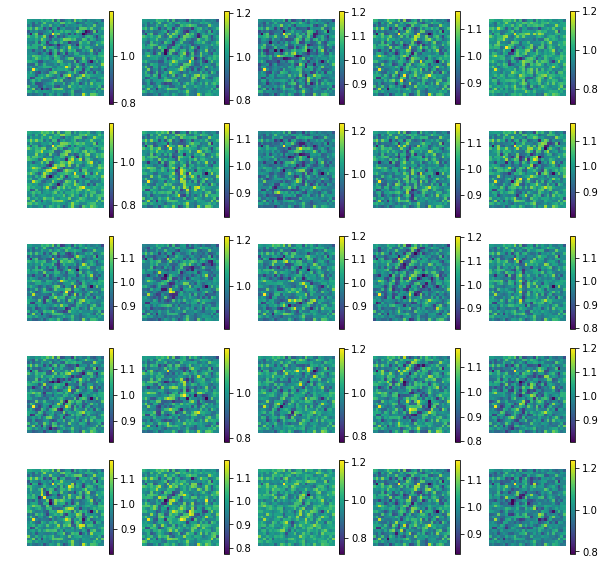

In [11]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()
plot_examples(image.eval())

Write your train loop here. Feel free to monitor loss and/or aperture/illumination phases during training. When we tested this, the optimizer had a slow start, and we had to run for several 1000 batches. Pick a value for the number of iterations and keep it fixed.

In [12]:
# train loop:
for i in range(5000):
    _, loss_i = sess.run([train_op, loss])
    if i%500 == 0:
        print(loss_i)

2.3031294
2.311421
2.2993298
2.301341
2.3095794
2.288938
2.2880087
2.282987
2.2330139
1.020008


Let's first look at a few simulated noisy microscope images AFTER training. Do the images look more recognizable?

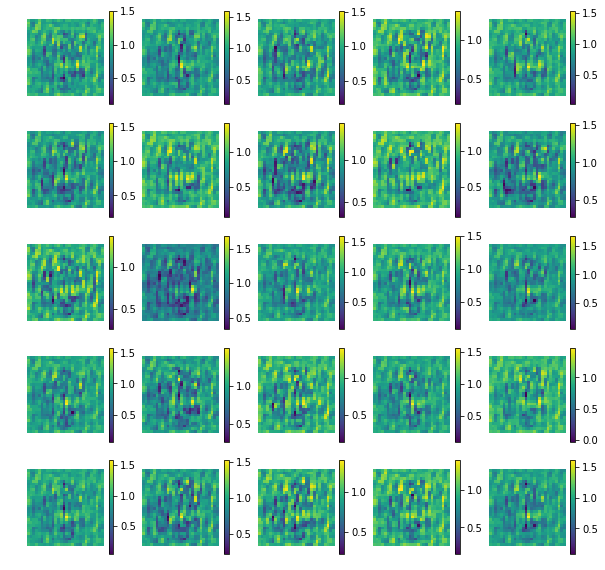

In [13]:
# plot examples 
plot_examples(image.eval())

Pass through the test set.

In [15]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_test, y_train_or_test: y_test})

# pass through test set:
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print(acc)

0.8084375


Ok, now you've run a machine learning model with a physical layer! You did it! Please respond to the following questions. Note that this is a pretty open-ended analysis, and everyone may achieve different results depending on the selected parameters -- as long as you get question 1 to work, it's okay if the other questions give uninteresting results!

1. First, using the default hyperparameters based on the instructions and code we provided, please run the training under the following conditions:
    1. Allowing optimization of aperture phase and illumination phase.
    2. Allowing optimization of neither aperture phase nor illumination phase (this is a control experiment, because only the CNN is trained).
    3. Allowing optimization of only the aperture phase.
    4. Allowing optimization of only the illumination phase.
    
    For these 4 conditions, report the final test classification accuracies as well as the optimized aperture phase and/or illumination phase. Provide a brief analysis of the results (hint: if you don't see a difference between at least two of the above conditions, something probably went wrong!).
   
2. If you got question 1 to work, good work! Next, let's try changing some of the hyperparameters above. For each of the following questions, rerun the analysis from question 1 (under conditions of 1A and 1B). Ideally, we want to find situations where the CNN with the physical layer (the microscope simulating layers) outperforms the CNN-only network. Comment on the gap in performance between the physically-optimized and non-physically-optimized cases. Also comment on the optimized aperture and/or illumination phase.

    * For question 1, you initialized with a constant phase. Next, try to initialize the optimization with random-valued aperture phase and illumination phase.
    * Try changing the diameter of the aperture to two other values. For example, half and double the original diameter used above.

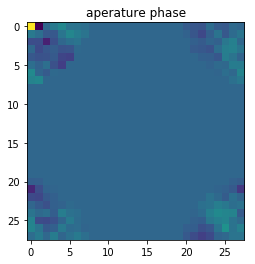

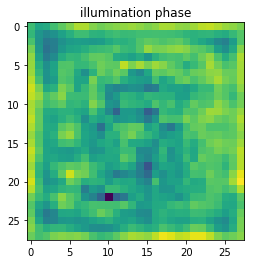

In [20]:
# part 1A Allowing optimization of aperture phase and illumination phase. 
# Accuracy = 0.9771875
plt.imshow(sess.run(aperture_phase))
plt.title('aperature phase')
plt.show()
plt.imshow(sess.run(input_illumination_phase))
plt.title('illumination phase')
plt.show()

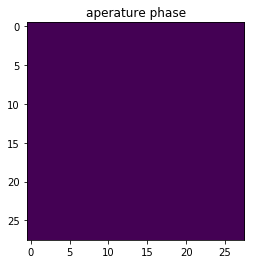

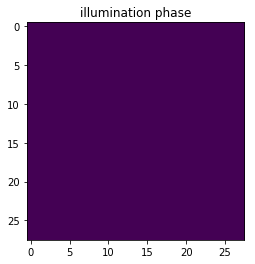

In [15]:
# part 1B Allowing optimization of neither aperture phase nor illumination phase. 
# Accuracy = 0.1125
plt.imshow(sess.run(aperture_phase))
plt.title('aperature phase')
plt.show()
plt.imshow(sess.run(input_illumination_phase))
plt.title('illumination phase')
plt.show()

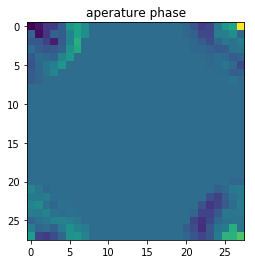

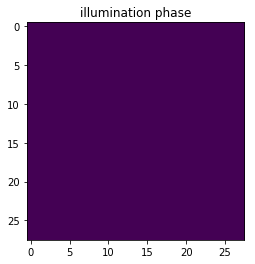

In [16]:
# part 1C Allowing optimization of only aperture phase
# Accuracy = 0.97625
plt.imshow(sess.run(aperture_phase))
plt.title('aperature phase')
plt.show()
plt.imshow(sess.run(input_illumination_phase))
plt.title('illumination phase')
plt.show()

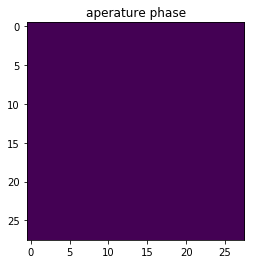

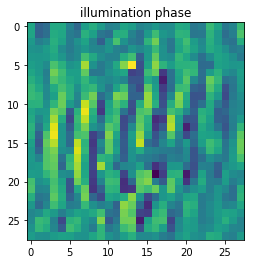

In [16]:
# part 1D Allowing optimization of only illumination phase
# Accuracy = 0.8059375
plt.imshow(sess.run(aperture_phase))
plt.title('aperature phase')
plt.show()
plt.imshow(sess.run(input_illumination_phase))
plt.title('illumination phase')
plt.show()